In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


In [ ]:
# ver1では一旦無視
# Ranking学習の場合、Taregetの数字を変える
# 1を1に、0を2に変える
# train_label['target'] = train_label['target'].replace(0, 2)

### Optuna

In [6]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import label_ranking_average_precision_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features = [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')]
target = 'target'
query_ids = 'session_id'

# Optunaでの目的関数の定義
def objective(trial):
    # Optunaで探索するパラメータ
    param = {
        'objective': 'lambdarank',
        'metric': 'map',
        'eval_at': [3, 5, 10],
        'boosting_type': 'gbdt',
        #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        #'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'seed': 42531,
    }

    map_scores = []
    for fold in range(5):
        # トレーニングデータとバリデーションデータの分割
        train_data = train_df[train_df['fold'] != fold]
        valid_data = train_df[train_df['fold'] == fold]

        # クエリごとのデータポイント数を計算
        train_groups = train_data.groupby(query_ids).size().values
        val_groups = valid_data.groupby(query_ids).size().values

        # LightGBMデータセットを作成
        lgb_train = lgb.Dataset(train_data[features], label=train_data[target], group=train_groups)
        lgb_val = lgb.Dataset(valid_data[features], label=valid_data[target], group=val_groups)

        # モデルの訓練
        model = lgb.train(param, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=100, verbose_eval=1)

        # バリデーションデータでの予測と評価
        valid_pred = model.predict(valid_data[features])
        map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
        map_scores.append(map_score)

    return np.mean(map_scores)

# Optunaのスタディを作成
study = optuna.create_study(direction='maximize')
# 15分で最適化を終了する
study.optimize(objective, timeout=600)
# 最適なパラメータを表示
print('Best trial:', study.best_trial.params)


[I 2023-12-16 14:19:14,572] A new study created in memory with name: no-name-48e46a17-84de-4dd4-a888-6e76725018ab
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's map@3: 0.753415	valid_0's map@5: 0.768724	valid_0's map@10: 0.785432
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.754015	valid_0's map@5: 0.769284	valid_0's map@10: 0.785993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.751091	valid_0's map@5: 0.766857	valid_0's map@10: 0.783621
[4]	valid_0's map@3: 0.751637	valid_0's map@5: 0.767367	valid_0's map@10: 0.784101
[LightGBM] [Warning] No further splits with 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's map@3: 0.75123	valid_0's map@5: 0.767173	valid_0's map@10: 0.783612
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.752124	valid_0's map@5: 0.768011	valid_0's map@10: 0.784458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.751689	valid_0's map@5: 0.767749	valid_0's map@10: 0.784199
[4]	valid_0's map@3: 0.752451	valid_0's map@5: 0.768325	valid_0's map@10: 0.784756
[LightGBM] [Warning] No further splits with p

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's map@3: 0.747813	valid_0's map@5: 0.764174	valid_0's map@10: 0.780895
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.746968	valid_0's map@5: 0.76332	valid_0's map@10: 0.780178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.746982	valid_0's map@5: 0.763034	valid_0's map@10: 0.780096
[4]	valid_0's map@3: 0.747787	valid_0's map@5: 0.763824	valid_0's map@10: 0.780841
[LightGBM] [Warning] No further splits with p

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750865	valid_0's map@5: 0.766469	valid_0's map@10: 0.783385
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750258	valid_0's map@5: 0.765934	valid_0's map@10: 0.782915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.748469	valid_0's map@5: 0.764417	valid_0's map@10: 0.781471
[4]	valid_0's map@3: 0.749658	valid_0's map@5: 0.76538	valid_0's map@10: 0.782412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@3: 0.750126	valid_0's map@5

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.749143	valid_0's map@5: 0.76495	valid_0's map@10: 0.781767
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.748384	valid_0's map@5: 0.764114	valid_0's map@10: 0.781101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.745589	valid_0's map@5: 0.762068	valid_0's map@10: 0.779116
[4]	valid_0's map@3: 0.746201	valid_0's map@5: 0.762674	valid_0's map@10: 0.779709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@3: 0.746366	valid_0's map@5

[I 2023-12-16 14:20:02,746] Trial 0 finished with value: 0.09488940216875758 and parameters: {'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 74, 'lambda_l1': 2.4309557060866926, 'lambda_l2': 4.51857969284533, 'min_gain_to_split': 0.6077184804263012, 'bagging_fraction': 0.7251752274656057, 'bagging_freq': 7, 'feature_fraction': 0.6388676721442036}. Best is trial 0 with value: 0.09488940216875758.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.752003	valid_0's map@5: 0.767382	valid_0's map@10: 0.784186
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.755623	valid_0's map@5: 0.771165	valid_0's map@10: 0.787497
[3]	valid_0's map@3: 0.757401	valid_0's map@5: 0.773023	valid_0's map@10: 0.788983
[4]	valid_0's map@3: 0.759321	valid_0's map@5: 0.774835	valid_0's map@10: 0.790542
[5]	valid_0's map@3: 0.75982	valid_0's map@5: 0.775333	valid_0's map@10: 0.790995
[6]	valid_0's map@3: 0.760481	valid_0's map@5: 0.775936	valid_0's map@10: 0.79156
[7]	valid_0's map@3: 0.760262	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.750791	valid_0's map@5: 0.76668	valid_0's map@10: 0.783302
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.75573	valid_0's map@5: 0.771071	valid_0's map@10: 0.787411
[3]	valid_0's map@3: 0.755822	valid_0's map@5: 0.771692	valid_0's map@10: 0.787738
[4]	valid_0's map@3: 0.757782	valid_0's map@5: 0.773484	valid_0's map@10: 0.789364
[5]	valid_0's map@3: 0.757753	valid_0's map@5: 0.773684	valid_0's map@10: 0.789473
[6]	valid_0's map@3: 0.758085	valid_0's map@5: 0.773952	valid_0's map@10: 0.789729
[7]	valid_0's map@3: 0.758965	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.748316	valid_0's map@5: 0.764637	valid_0's map@10: 0.781357
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.752547	valid_0's map@5: 0.76858	valid_0's map@10: 0.784925
[3]	valid_0's map@3: 0.752804	valid_0's map@5: 0.769042	valid_0's map@10: 0.785273
[4]	valid_0's map@3: 0.755295	valid_0's map@5: 0.771298	valid_0's map@10: 0.787306
[5]	valid_0's map@3: 0.754992	valid_0's map@5: 0.771127	valid_0's map@10: 0.787242
[6]	valid_0's map@3: 0.755824	valid_0's map@5: 0.77203	valid_0's map@10: 0.787941
[7]	valid_0's map@3: 0.756242	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.751852	valid_0's map@5: 0.767759	valid_0's map@10: 0.784407
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.753344	valid_0's map@5: 0.769377	valid_0's map@10: 0.785517
[3]	valid_0's map@3: 0.755763	valid_0's map@5: 0.771949	valid_0's map@10: 0.787727
[4]	valid_0's map@3: 0.756923	valid_0's map@5: 0.772433	valid_0's map@10: 0.788437
[5]	valid_0's map@3: 0.758118	valid_0's map@5: 0.773915	valid_0's map@10: 0.789528
[6]	valid_0's map@3: 0.758523	valid_0's map@5: 0.774378	valid_0's map@10: 0.789972
[7]	valid_0's map@3: 0.75949

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.747076	valid_0's map@5: 0.7633	valid_0's map@10: 0.780238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.753002	valid_0's map@5: 0.768376	valid_0's map@10: 0.785038
[3]	valid_0's map@3: 0.75299	valid_0's map@5: 0.768953	valid_0's map@10: 0.785295
[4]	valid_0's map@3: 0.755444	valid_0's map@5: 0.771287	valid_0's map@10: 0.787357
[5]	valid_0's map@3: 0.755597	valid_0's map@5: 0.771181	valid_0's map@10: 0.787143
[6]	valid_0's map@3: 0.756336	valid_0's map@5: 0.77214	valid_0's map@10: 0.788104
[7]	valid_0's map@3: 0.756956	va

[I 2023-12-16 14:21:28,475] Trial 1 finished with value: 0.09574345312483801 and parameters: {'num_leaves': 49, 'max_depth': 10, 'min_data_in_leaf': 63, 'lambda_l1': 4.351988818443737, 'lambda_l2': 3.356250721334693, 'min_gain_to_split': 0.4828173014657735, 'bagging_fraction': 0.8162793783596316, 'bagging_freq': 6, 'feature_fraction': 0.886575034158255}. Best is trial 1 with value: 0.09574345312483801.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.753337	valid_0's map@5: 0.768464	valid_0's map@10: 0.785312
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750367	valid_0's map@5: 0.765675	valid_0's map@10: 0.782664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.747278	valid_0's map@5: 0.762908	valid_0's map@10: 0.780147
[4]	valid_0's map@3: 0.750127	valid_0's map@5: 0.765744	valid_0's map@10: 0.782618
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.75159	valid_0's map@5: 0.767316	valid_0's map@10: 0.7838
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.748739	valid_0's map@5: 0.764598	valid_0's map@10: 0.781309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.746545	valid_0's map@5: 0.762517	valid_0's map@10: 0.779564
[4]	valid_0's map@3: 0.749489	valid_0's map@5: 0.765406	valid_0's map@10: 0.782269
[LightGBM] [Warning] No further splits with positive gain,

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747785	valid_0's map@5: 0.764079	valid_0's map@10: 0.780937
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.745487	valid_0's map@5: 0.761814	valid_0's map@10: 0.778888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.745057	valid_0's map@5: 0.76125	valid_0's map@10: 0.778413
[4]	valid_0's map@3: 0.747686	valid_0's map@5: 0.763817	valid_0's map@10: 0.780762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@3: 0.748261	valid_0's map@5

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750968	valid_0's map@5: 0.766445	valid_0's map@10: 0.783402
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.749109	valid_0's map@5: 0.764657	valid_0's map@10: 0.78183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.746624	valid_0's map@5: 0.762871	valid_0's map@10: 0.779966
[4]	valid_0's map@3: 0.749996	valid_0's map@5: 0.765651	valid_0's map@10: 0.782611
[LightGBM] [Warning] No further splits with positive gai

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.749304	valid_0's map@5: 0.765143	valid_0's map@10: 0.781933
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.746551	valid_0's map@5: 0.762432	valid_0's map@10: 0.77952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.745079	valid_0's map@5: 0.76119	valid_0's map@10: 0.778366
[4]	valid_0's map@3: 0.747705	valid_0's map@5: 0.763611	valid_0's map@10: 0.780655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@3: 0.748294	valid_0's map@5:

[I 2023-12-16 14:22:23,671] Trial 2 finished with value: 0.0994522231870277 and parameters: {'num_leaves': 79, 'max_depth': 4, 'min_data_in_leaf': 49, 'lambda_l1': 1.9419667207051639, 'lambda_l2': 1.0503876281338438, 'min_gain_to_split': 0.45313972537708713, 'bagging_fraction': 0.47062828211389984, 'bagging_freq': 1, 'feature_fraction': 0.44509058384880107}. Best is trial 2 with value: 0.0994522231870277.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument inste

[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.752924	valid_0's map@5: 0.768158	valid_0's map@10: 0.784939
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@3: 0.748516	valid_0's map@5: 0.764467	valid_0's map@10: 0.781506
[3]	valid_0's map@3: 0.753773	valid_0's map@5: 0.768656	valid_0's map@10: 0.785438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's map@3: 0.753138	valid_0's map@5: 0.768982	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.311467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.750231	valid_0's map@5: 0.765989	valid_0's map@10: 0.782811
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@3: 0.749111	valid_0's map@5: 0.765286	valid_0's map@10: 0.782082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.750266	valid_0's map@5: 0.76637	valid_0's map@10: 0.783116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's map@3: 0.751547	valid_0's map@5: 0.7672

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747499	valid_0's map@5: 0.763834	valid_0's map@10: 0.780678
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@3: 0.749118	valid_0's map@5: 0.764874	valid_0's map@10: 0.781684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.749794	valid_0's map@5: 0.765666	valid_0's map@10: 0.782424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's map@3: 0.7515	valid_0's map@5: 0.76722

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750302	valid_0's map@5: 0.765951	valid_0's map@10: 0.782899
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@3: 0.750377	valid_0's map@5: 0.766294	valid_0's map@10: 0.783062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.752065	valid_0's map@5: 0.767527	valid_0's map@10: 0.784349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's map@3: 0.752383	valid_0's map@5: 0.768

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.749099	valid_0's map@5: 0.764732	valid_0's map@10: 0.781707
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's map@3: 0.748245	valid_0's map@5: 0.763972	valid_0's map@10: 0.781182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.749726	valid_0's map@5: 0.765327	valid_0's map@10: 0.782311
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-12-16 14:23:45,302] Trial 3 finished with value: 0.09478167953185083 and parameters: {'num_leaves': 25, 'max_depth': 5, 'min_data_in_leaf': 34, 'lambda_l1': 4.415718221158391, 'lambda_l2': 0.4894909141739717, 'min_gain_to_split': 0.5903215246687485, 'bagging_fraction': 0.8077996625202699, 'bagging_freq': 2, 'feature_fraction': 0.9821009784357447}. Best is trial 2 with value: 0.0994522231870277.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.752835	valid_0's map@5: 0.768134	valid_0's map@10: 0.784841
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750332	valid_0's map@5: 0.766073	valid_0's map@10: 0.782881
[3]	valid_0's map@3: 0.754587	valid_0's map@5: 0.770582	valid_0's map@10: 0.786792
[4]	valid_0's map@3: 0.755464	valid_0's map@5: 0.771089	valid_0's map@10: 0.787232
[5]	valid_0's map@3: 0.756529	valid_0's map@5: 0.771991	valid_0's map@10: 0.788162
[6]	valid_0's map@3: 0.759072	valid_0's map@5: 0.774397	valid_0's map@10: 0.790229
[7]	valid_0's map@3: 0.75870

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.751443	valid_0's map@5: 0.767479	valid_0's map@10: 0.783783
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.753242	valid_0's map@5: 0.768903	valid_0's map@10: 0.785319
[3]	valid_0's map@3: 0.75351	valid_0's map@5: 0.769304	valid_0's map@10: 0.785641
[4]	valid_0's map@3: 0.75506	valid_0's map@5: 0.770728	valid_0's map@10: 0.787013
[5]	valid_0's map@3: 0.755975	valid_0's map@5: 0.771735	valid_0's map@10: 0.787784
[6]	valid_0's map@3: 0.757014	valid_0's map@5: 0.772577	valid_0's map@10: 0.788592
[7]	valid_0's map@3: 0.758177	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747502	valid_0's map@5: 0.763866	valid_0's map@10: 0.780593
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.749375	valid_0's map@5: 0.765249	valid_0's map@10: 0.782104
[3]	valid_0's map@3: 0.750758	valid_0's map@5: 0.766543	valid_0's map@10: 0.783474
[4]	valid_0's map@3: 0.752429	valid_0's map@5: 0.768433	valid_0's map@10: 0.785023
[5]	valid_0's map@3: 0.753104	valid_0's map@5: 0.768743	valid_0's map@10: 0.785191
[6]	valid_0's map@3: 0.75337	valid_0's map@5: 0.769382	valid_0's map@10: 0.7857
[7]	valid_0's map@3: 0.753791	v

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.751246	valid_0's map@5: 0.766829	valid_0's map@10: 0.783598
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751003	valid_0's map@5: 0.767311	valid_0's map@10: 0.783896
[3]	valid_0's map@3: 0.753298	valid_0's map@5: 0.769155	valid_0's map@10: 0.785505
[4]	valid_0's map@3: 0.755942	valid_0's map@5: 0.771332	valid_0's map@10: 0.787551
[5]	valid_0's map@3: 0.756499	valid_0's map@5: 0.771794	valid_0's map@10: 0.787917
[6]	valid_0's map@3: 0.757838	valid_0's map@5: 0.773271	valid_0's map@10: 0.789268
[7]	valid_0's map@3: 0.75845

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.749541	valid_0's map@5: 0.765504	valid_0's map@10: 0.78222
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.748736	valid_0's map@5: 0.764835	valid_0's map@10: 0.781664
[3]	valid_0's map@3: 0.753487	valid_0's map@5: 0.768956	valid_0's map@10: 0.785401
[4]	valid_0's map@3: 0.754266	valid_0's map@5: 0.769875	valid_0's map@10: 0.786392
[5]	valid_0's map@3: 0.754942	valid_0's map@5: 0.770497	valid_0's map@10: 0.78692
[6]	valid_0's map@3: 0.755507	valid_0's map@5: 0.771046	valid_0's map@10: 0.787358
[7]	valid_0's map@3: 0.75674	v

[I 2023-12-16 14:25:04,370] Trial 4 finished with value: 0.09558458221223333 and parameters: {'num_leaves': 36, 'max_depth': 8, 'min_data_in_leaf': 27, 'lambda_l1': 3.731535188270141, 'lambda_l2': 3.076835980168645, 'min_gain_to_split': 0.35106591066655546, 'bagging_fraction': 0.7895672427201514, 'bagging_freq': 5, 'feature_fraction': 0.8037041054266367}. Best is trial 2 with value: 0.0994522231870277.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.753031	valid_0's map@5: 0.768317	valid_0's map@10: 0.785067
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750456	valid_0's map@5: 0.766142	valid_0's map@10: 0.783142
[3]	valid_0's map@3: 0.755126	valid_0's map@5: 0.771206	valid_0's map@10: 0.78738
[4]	valid_0's map@3: 0.756414	valid_0's map@5: 0.771904	valid_0's map@10: 0.788075
[5]	valid_0's map@3: 0.756584	valid_0's map@5: 0.771818	valid_0's map@10: 0.788247
[6]	valid_0's map@3: 0.757592	valid_0's map@5: 0.773022	valid_0's map@10: 0.789168
[7]	valid_0's map@3: 0.758316

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.75086	valid_0's map@5: 0.766755	valid_0's map@10: 0.78328
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750554	valid_0's map@5: 0.76682	valid_0's map@10: 0.78335
[3]	valid_0's map@3: 0.75254	valid_0's map@5: 0.768575	valid_0's map@10: 0.785057
[4]	valid_0's map@3: 0.754217	valid_0's map@5: 0.769957	valid_0's map@10: 0.786532
[5]	valid_0's map@3: 0.75515	valid_0's map@5: 0.770916	valid_0's map@10: 0.787271
[6]	valid_0's map@3: 0.756001	valid_0's map@5: 0.771907	valid_0's map@10: 0.788079
[7]	valid_0's map@3: 0.756486	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747721	valid_0's map@5: 0.764098	valid_0's map@10: 0.780841
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.749577	valid_0's map@5: 0.7654	valid_0's map@10: 0.782335
[3]	valid_0's map@3: 0.749811	valid_0's map@5: 0.765868	valid_0's map@10: 0.782575
[4]	valid_0's map@3: 0.751061	valid_0's map@5: 0.767188	valid_0's map@10: 0.783733
[5]	valid_0's map@3: 0.75238	valid_0's map@5: 0.768558	valid_0's map@10: 0.784929
[6]	valid_0's map@3: 0.753024	valid_0's map@5: 0.769206	valid_0's map@10: 0.785508
[7]	valid_0's map@3: 0.754325	v

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750377	valid_0's map@5: 0.766077	valid_0's map@10: 0.782961
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750452	valid_0's map@5: 0.766108	valid_0's map@10: 0.783163
[3]	valid_0's map@3: 0.751341	valid_0's map@5: 0.766939	valid_0's map@10: 0.78372
[4]	valid_0's map@3: 0.753688	valid_0's map@5: 0.76917	valid_0's map@10: 0.785732
[5]	valid_0's map@3: 0.75518	valid_0's map@5: 0.770782	valid_0's map@10: 0.787035
[6]	valid_0's map@3: 0.755489	valid_0's map@5: 0.770989	valid_0's map@10: 0.78732
[7]	valid_0's map@3: 0.757287	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.748571	valid_0's map@5: 0.764683	valid_0's map@10: 0.781384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.749483	valid_0's map@5: 0.765771	valid_0's map@10: 0.782525
[3]	valid_0's map@3: 0.750658	valid_0's map@5: 0.766422	valid_0's map@10: 0.783314
[4]	valid_0's map@3: 0.751533	valid_0's map@5: 0.767417	valid_0's map@10: 0.784147
[5]	valid_0's map@3: 0.75347	valid_0's map@5: 0.769262	valid_0's map@10: 0.785723
[6]	valid_0's map@3: 0.753464	valid_0's map@5: 0.769293	valid_0's map@10: 0.785741
[7]	valid_0's map@3: 0.754307

[I 2023-12-16 14:26:06,595] Trial 5 finished with value: 0.09515128977567615 and parameters: {'num_leaves': 29, 'max_depth': 10, 'min_data_in_leaf': 69, 'lambda_l1': 0.3244881717171516, 'lambda_l2': 4.936348283027, 'min_gain_to_split': 0.3284976580165546, 'bagging_fraction': 0.48152822678340645, 'bagging_freq': 2, 'feature_fraction': 0.8134343358224487}. Best is trial 2 with value: 0.0994522231870277.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.750857	valid_0's map@5: 0.766455	valid_0's map@10: 0.783413
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.754312	valid_0's map@5: 0.769435	valid_0's map@10: 0.78613
[3]	valid_0's map@3: 0.757337	valid_0's map@5: 0.772757	valid_0's map@10: 0.788866
[4]	valid_0's map@3: 0.75883	valid_0's map@5: 0.77431	valid_0's map@10: 0.790054
[5]	valid_0's map@3: 0.759179	valid_0's map@5: 0.774383	valid_0's map@10: 0.790269
[6]	valid_0's map@3: 0.759462	valid_0's map@5: 0.774743	valid_0's map@10: 0.790514
[7]	valid_0's map@3: 0.759794	v

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.751227	valid_0's map@5: 0.766745	valid_0's map@10: 0.783653
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.753478	valid_0's map@5: 0.769147	valid_0's map@10: 0.785823
[3]	valid_0's map@3: 0.75439	valid_0's map@5: 0.770295	valid_0's map@10: 0.786515
[4]	valid_0's map@3: 0.756345	valid_0's map@5: 0.771989	valid_0's map@10: 0.788156
[5]	valid_0's map@3: 0.756674	valid_0's map@5: 0.772273	valid_0's map@10: 0.788442
[6]	valid_0's map@3: 0.75775	valid_0's map@5: 0.773496	valid_0's map@10: 0.789516
[7]	valid_0's map@3: 0.758602	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747132	valid_0's map@5: 0.76325	valid_0's map@10: 0.780332
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751139	valid_0's map@5: 0.766861	valid_0's map@10: 0.783581
[3]	valid_0's map@3: 0.752227	valid_0's map@5: 0.768252	valid_0's map@10: 0.784648
[4]	valid_0's map@3: 0.754063	valid_0's map@5: 0.770189	valid_0's map@10: 0.786441
[5]	valid_0's map@3: 0.754213	valid_0's map@5: 0.770236	valid_0's map@10: 0.786509
[6]	valid_0's map@3: 0.754796	valid_0's map@5: 0.770478	valid_0's map@10: 0.786786
[7]	valid_0's map@3: 0.754761

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750481	valid_0's map@5: 0.766442	valid_0's map@10: 0.783183
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.753771	valid_0's map@5: 0.769518	valid_0's map@10: 0.785736
[3]	valid_0's map@3: 0.754744	valid_0's map@5: 0.770475	valid_0's map@10: 0.786704
[4]	valid_0's map@3: 0.755405	valid_0's map@5: 0.771112	valid_0's map@10: 0.787331
[5]	valid_0's map@3: 0.755925	valid_0's map@5: 0.771619	valid_0's map@10: 0.787801
[6]	valid_0's map@3: 0.756788	valid_0's map@5: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.74847	valid_0's map@5: 0.764099	valid_0's map@10: 0.781263
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751192	valid_0's map@5: 0.767013	valid_0's map@10: 0.783631
[3]	valid_0's map@3: 0.755201	valid_0's map@5: 0.770668	valid_0's map@10: 0.787033
[4]	valid_0's map@3: 0.756711	valid_0's map@5: 0.772348	valid_0's map@10: 0.788352
[5]	valid_0's map@3: 0.75691	valid_0's map@5: 0.772389	valid_0's map@10: 0.78844
[6]	valid_0's map@3: 0.757597	valid_0's map@5: 0.773202	valid_0's map@10: 0.789096
[7]	valid_0's map@3: 0.757568	v

[I 2023-12-16 14:27:09,083] Trial 6 finished with value: 0.09448003019572726 and parameters: {'num_leaves': 36, 'max_depth': 9, 'min_data_in_leaf': 56, 'lambda_l1': 3.3127060632106176, 'lambda_l2': 0.04443160276535352, 'min_gain_to_split': 0.6211549446789262, 'bagging_fraction': 0.47823283800743743, 'bagging_freq': 7, 'feature_fraction': 0.8489828143554958}. Best is trial 2 with value: 0.0994522231870277.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument inste

[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.754708	valid_0's map@5: 0.770513	valid_0's map@10: 0.786642
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.756457	valid_0's map@5: 0.772202	valid_0's map@10: 0.788163
[3]	valid_0's map@3: 0.758942	valid_0's map@5: 0.774294	valid_0's map@10: 0.790293
[4]	valid_0's map@3: 0.759041	valid_0's map@5: 0.774401	valid_0's map@10: 0.790391
[5]	valid_0's map@3: 0.759026	valid_0's map@5: 0.774107	valid_0's map@10: 0.79016
[6]	valid_0's map@3: 0.758928	valid_0's map@5: 0.774137	valid_0's map@10: 0.790231
[7]	valid_0's map@3: 0.760158

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.753369	valid_0's map@5: 0.769654	valid_0's map@10: 0.785745
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.756405	valid_0's map@5: 0.772117	valid_0's map@10: 0.788131
[3]	valid_0's map@3: 0.757496	valid_0's map@5: 0.773018	valid_0's map@10: 0.789101
[4]	valid_0's map@3: 0.758001	valid_0's map@5: 0.773805	valid_0's map@10: 0.789708
[5]	valid_0's map@3: 0.758896	valid_0's map@5: 0.774597	valid_0's map@10: 0.790308
[6]	valid_0's map@3: 0.75872	valid_0's map@5: 0.774146	valid_0's map@10: 0.79012
[7]	valid_0's map@3: 0.759127	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.749906	valid_0's map@5: 0.766401	valid_0's map@10: 0.782933
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.753918	valid_0's map@5: 0.769838	valid_0's map@10: 0.786093
[3]	valid_0's map@3: 0.753823	valid_0's map@5: 0.769824	valid_0's map@10: 0.786088
[4]	valid_0's map@3: 0.754701	valid_0's map@5: 0.770712	valid_0's map@10: 0.786846
[5]	valid_0's map@3: 0.755428	valid_0's map@5: 0.771294	valid_0's map@10: 0.787435
[6]	valid_0's map@3: 0.755922	valid_0's map@5: 0.771823	valid_0's map@10: 0.787864
[7]	valid_0's map@3: 0.75651

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750847	valid_0's map@5: 0.767064	valid_0's map@10: 0.783509
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.753563	valid_0's map@5: 0.769179	valid_0's map@10: 0.785722
[3]	valid_0's map@3: 0.755203	valid_0's map@5: 0.770915	valid_0's map@10: 0.78726
[4]	valid_0's map@3: 0.7574	valid_0's map@5: 0.772872	valid_0's map@10: 0.788926
[5]	valid_0's map@3: 0.757564	valid_0's map@5: 0.773088	valid_0's map@10: 0.78916
[6]	valid_0's map@3: 0.758254	valid_0's map@5: 0.77364	valid_0's map@10: 0.789646
[7]	valid_0's map@3: 0.758107	val

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.751383	valid_0's map@5: 0.767591	valid_0's map@10: 0.783989
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.754745	valid_0's map@5: 0.77049	valid_0's map@10: 0.786701
[3]	valid_0's map@3: 0.755277	valid_0's map@5: 0.771101	valid_0's map@10: 0.78724
[4]	valid_0's map@3: 0.755421	valid_0's map@5: 0.771285	valid_0's map@10: 0.787293
[5]	valid_0's map@3: 0.755678	valid_0's map@5: 0.771494	valid_0's map@10: 0.787459
[6]	valid_0's map@3: 0.755834	valid_0's map@5: 0.771648	valid_0's map@10: 0.787525
[7]	valid_0's map@3: 0.756194	

[I 2023-12-16 14:28:46,448] Trial 7 finished with value: 0.0988189379037479 and parameters: {'num_leaves': 97, 'max_depth': 9, 'min_data_in_leaf': 78, 'lambda_l1': 4.677696061580781, 'lambda_l2': 1.129950042668046, 'min_gain_to_split': 0.9194278615875493, 'bagging_fraction': 0.6011364516867079, 'bagging_freq': 1, 'feature_fraction': 0.9801773356478547}. Best is trial 2 with value: 0.0994522231870277.
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.752459	valid_0's map@5: 0.767978	valid_0's map@10: 0.784682
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.755681	valid_0's map@5: 0.7714

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.750828	valid_0's map@5: 0.766838	valid_0's map@10: 0.783391
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.75338	valid_0's map@5: 0.76928

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747539	valid_0's map@5: 0.763798	valid_0's map@10: 0.78062
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.749164	valid_0's map@5: 0.76531

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750091	valid_0's map@5: 0.765736	valid_0's map@10: 0.782672
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.752879	valid_0's map@5: 0.7682

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.74901	valid_0's map@5: 0.765168	valid_0's map@10: 0.781881
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.751253	valid_0's map@5: 0.76717

[I 2023-12-16 14:29:43,360] Trial 8 finished with value: 0.09631403185023199 and parameters: {'num_leaves': 31, 'max_depth': 8, 'min_data_in_leaf': 20, 'lambda_l1': 4.586107091486708, 'lambda_l2': 2.4294406487709264, 'min_gain_to_split': 0.8339684356659742, 'bagging_fraction': 0.433634949826053, 'bagging_freq': 7, 'feature_fraction': 0.6606506942150377}. Best is trial 2 with value: 0.0994522231870277.


Best trial: {'num_leaves': 79, 'max_depth': 4, 'min_data_in_leaf': 49, 'lambda_l1': 1.9419667207051639, 'lambda_l2': 1.0503876281338438, 'min_gain_to_split': 0.45313972537708713, 'bagging_fraction': 0.47062828211389984, 'bagging_freq': 1, 'feature_fraction': 0.44509058384880107}


### LightGBM Ranker（candidate用のRankerモデル）

In [7]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad')] # seen_yadも入れる
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# LightGBM のパラメータ
'''
params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': [3, 5, 10],
    # 'label_gain':"0,1,5",　# ここを指定すると、ターゲットの重み付けができる　https://blog.recruit.co.jp/data/articles/lgbm_rank/
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators' : 5000,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42531,
}
'''

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'eval_at': [3, 5, 10],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators' : 5000,
    'seed': 42531,
    'num_leaves': 79, 
    'max_depth': 4, 
    'min_data_in_leaf': 49, 
    'lambda_l1': 1.9419667207051639, 
    'lambda_l2': 1.0503876281338438, 
    'min_gain_to_split': 0.45313972537708713, 
    'bagging_fraction': 0.47062828211389984, 
    'bagging_freq': 1, 
    'feature_fraction': 0.44509058384880107
}

In [8]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score

map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # クエリごとのデータポイント数を計算
    train_groups = train_data.groupby(query_ids).size().values
    val_groups = valid_data.groupby(query_ids).size().values

    # LightGBMデータセットを作成
    lgb_train = lgb.Dataset(train_data[features], label=train_data[target], group=train_groups)
    lgb_val = lgb.Dataset(valid_data[features], label=valid_data[target], group=val_groups)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_val], early_stopping_rounds=100, verbose_eval=1)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(valid_data[features])
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存
    
    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.753337	valid_0's map@5: 0.768464	valid_0's map@10: 0.785312
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.750248	valid_0's map@5: 0.765648	valid_0's map@10: 0.78262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.747385	valid_0's map@5: 0.76311	valid_0's map@10: 0.780263
[4]	valid_0's map@3: 0.749818	valid_0's map@5: 0.765324	valid_0's map@10: 0.782299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@3: 0.75004	valid_0's map@5: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 2222019, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555508
[1]	valid_0's map@3: 0.75159	valid_0's map@5: 0.767316	valid_0's map@10: 0.7838
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.748704	valid_0's map@5: 0.764628	valid_0's map@10: 0.781323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.747913	valid_0's map@5: 0.763859	valid_0's map@10: 0.780749
[4]	valid_0's map@3: 0.750294	valid_0's map@5: 0.766061	valid_0's map@10: 0.782736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's map@3: 0.750753	valid_0's map@5: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.747785	valid_0's map@5: 0.764079	valid_0's map@10: 0.780937
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.745178	valid_0's map@5: 0.761385	valid_0's map@10: 0.778613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.744731	valid_0's map@5: 0.761035	valid_0's map@10: 0.778214
[4]	valid_0's map@3: 0.747095	valid_0's map@5: 0.763312	valid_0's map@10: 0.780239
[LightGBM] [Warning] No further splits with positive ga

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230959, total data: 2222025
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 2222025, number of used features: 36
[LightGBM] [Info] Total groups: 57739, total data: 555502
[1]	valid_0's map@3: 0.750968	valid_0's map@5: 0.766445	valid_0's map@10: 0.783402
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.74883	valid_0's map@5: 0.764338	valid_0's map@10: 0.781503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.746491	valid_0's map@5: 0.762491	valid_0's map@10: 0.779676
[4]	valid_0's map@3: 0.749447	valid_0's map@5: 0.765053	valid_0's map@10: 0.781955
[LightGBM] [Warning] No further splits with positive gai

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 230958, total data: 2222020
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5147
[LightGBM] [Info] Number of data points in the train set: 2222020, number of used features: 36
[LightGBM] [Info] Total groups: 57740, total data: 555507
[1]	valid_0's map@3: 0.749304	valid_0's map@5: 0.765143	valid_0's map@10: 0.781933
Training until validation scores don't improve for 100 rounds
[2]	valid_0's map@3: 0.746346	valid_0's map@5: 0.762304	valid_0's map@10: 0.77944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's map@3: 0.745393	valid_0's map@5: 0.761393	valid_0's map@10: 0.778656
[4]	valid_0's map@3: 0.748014	valid_0's map@5: 0.763838	valid_0's map@10: 0.780792
[LightGBM] [Warning] No further splits with positive gai

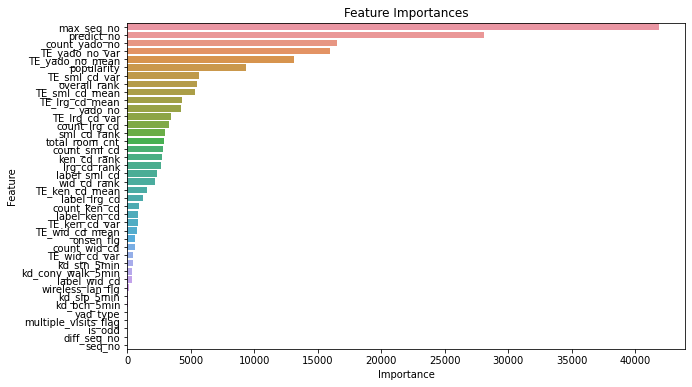

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 特徴量重要度の取得
feature_importances = model.feature_importance(importance_type='gain')

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [10]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [11]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.305264
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.152954
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.358701
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.658204
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.744340


In [12]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.305264
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.152954
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.358701
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.658204
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.744340
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.696604
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.875200
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.842131
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.930440


In [13]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.305264
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.152954
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.358701
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.658204
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.744340
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.696604
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.875200
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.842131
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.930440


In [14]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/lgbRanker_ver14_oof_pred.csv', index=False)

In [15]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.305264
1,000104bdffaaad1a1e0a9ebacf585f33,7749,-0.152954
2,000104bdffaaad1a1e0a9ebacf585f33,902,-0.358701
3,000104bdffaaad1a1e0a9ebacf585f33,11380,-0.658204
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.744340
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.696604
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.875200
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.842131
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-2.930440


### CVの計算

In [16]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [17]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [18]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 5490, 1284, 12491, 4072, 254]
CPU times: user 153 ms, sys: 19 µs, total: 153 ms
Wall time: 153 ms


In [19]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:43<00:00, 6595.33it/s]


In [20]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,11882,997,5289,12846,3324,9208,9207,9209
1,8253,8747,11104,4488,2259,2570,1586,8225,3564,3725
2,4863,4355,6722,9039,7509,2957,13642,5238,1967,11724
3,626,2272,13549,755,11715,7812,109,13296,1341,7872
4,96,3894,7749,902,11380,5490,1284,12491,4072,254
...,...,...,...,...,...,...,...,...,...,...
288693,13079,13210,10955,3725,10522,5719,8677,13717,2876,1586
288694,4767,2900,963,8703,6654,3940,8465,399,513,5299
288695,12240,7308,10364,4040,2087,4398,3566,7820,9558,844
288696,10619,570,12500,11091,7551,3238,12829,12781,10616,11316


### 要素の集合にバグがないかを確認

In [21]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [22]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムの数を確認する

In [23]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [24]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
281327


In [25]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [26]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,4101,2808,11882,997,5289,12846,3324,9208,9207,9209
1,8253,8747,11104,4488,2259,2570,1586,8225,3564,3725
2,4863,4355,6722,9039,7509,2957,13642,5238,1967,11724
3,626,2272,13549,755,11715,7812,109,13296,1341,7872
4,96,3894,7749,902,11380,5490,1284,12491,4072,254
5,4823,12544,10510,5369,9207,9199,9201,1,9202,9200
6,7531,12774,2480,13240,4574,441,2282,7273,10378,10442
7,111,10544,4744,9508,10362,7681,12962,12464,1755,12125
8,3644,3802,899,4014,13220,1227,13702,9723,12432,2164
9,3278,10478,3483,379,9773,6592,550,4303,2806,9430


In [27]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [28]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [29]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.43266977399461864


In [30]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [31]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [32]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,4101,2808,11882,997,5289,12846,3324,9208,9207,9209,False
1,8253,8747,11104,4488,2259,2570,1586,8225,3564,3725,False
2,4863,4355,6722,9039,7509,2957,13642,5238,1967,11724,False
3,626,2272,13549,755,11715,7812,109,13296,1341,7872,False
4,96,3894,7749,902,11380,5490,1284,12491,4072,254,False


### 推論用の候補テーブル作成

In [33]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [34]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.31259529 -0.33404372 -0.28771548 ... -0.14163456 -0.17781979
 -0.13747628]
1683604


In [35]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [36]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [37]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.312595
1,00001149e9c73985425197104712478c,4714,-0.334044
2,00001149e9c73985425197104712478c,2680,-0.287715
3,00001149e9c73985425197104712478c,4420,-0.796368
4,00001149e9c73985425197104712478c,5466,-0.711332


In [38]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.312595
1,00001149e9c73985425197104712478c,4714,-0.334044
2,00001149e9c73985425197104712478c,2680,-0.287715
3,00001149e9c73985425197104712478c,4420,-0.796368
4,00001149e9c73985425197104712478c,5466,-0.711332
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.102961
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.101685
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.141635
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.177820


In [39]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.312595
1,00001149e9c73985425197104712478c,4714,-0.334044
2,00001149e9c73985425197104712478c,2680,-0.287715
3,00001149e9c73985425197104712478c,4420,-0.796368
4,00001149e9c73985425197104712478c,5466,-0.711332
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.102961
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.101685
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.141635
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.177820


In [40]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.312595
1,00001149e9c73985425197104712478c,4714,-0.334044
2,00001149e9c73985425197104712478c,2680,-0.287715
3,00001149e9c73985425197104712478c,4420,-0.796368
4,00001149e9c73985425197104712478c,5466,-0.711332
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,-0.102961
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,-0.101685
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.141635
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,-0.177820


In [42]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/lgbRanker_ver14_test_pred.csv', index=False)

In [43]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [44]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[10729, 11723, 1891, 12767, 3781, 5623, 867, 12620, 11994, 634]
CPU times: user 91.6 ms, sys: 3.98 ms, total: 95.5 ms
Wall time: 95.4 ms


In [45]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:26<00:00, 6637.07it/s]


In [46]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,9830,5466,4420,9534,6563,5785
1,8108,6129,613,7014,11923,4066,143,6555,11237,12862
2,757,9190,7710,1774,9910,10485,410,6721,13570,6730
3,12341,3359,6991,1542,13521,10861,5080,4180,6489,10746
4,12029,10826,3476,2862,3854,9623,9020,5372,3844,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,9743,10042,3440
174696,899,3644,13220,3802,4014,1227,13702,12432,9723,2164
174697,2087,7308,12939,13719,13797,13241,11037,11796,8143,5810
174698,3100,10287,3002,2373,13672,4976,2692,12281,1687,5513


In [48]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [49]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [50]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [51]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


In [52]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [53]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,9830,5466,4420,9534,6563,5785,False
1,8108,6129,613,7014,11923,4066,143,6555,11237,12862,False
2,757,9190,7710,1774,9910,10485,410,6721,13570,6730,False
3,12341,3359,6991,1542,13521,10861,5080,4180,6489,10746,False
4,12029,10826,3476,2862,3854,9623,9020,5372,3844,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,10997,2278,9743,10042,3440,False
174696,899,3644,13220,3802,4014,1227,13702,12432,9723,2164,False
174697,2087,7308,12939,13719,13797,13241,11037,11796,8143,5810,False
174698,3100,10287,3002,2373,13672,4976,2692,12281,1687,5513,False


In [54]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/lgbRanker_ver14.csv', index=False)